In [1]:
import pandas as pd
from enum import Enum
from matplotlib import pyplot as plt
import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors import factor_product

from sklearn.preprocessing import KBinsDiscretizer

/home/snowtsuku/.miniconda3/envs/DT8057/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We have to make some assumption to make the network. The assumption is defined
as below:

* `annual_income` depends on `age` and `region`
* `purchase_frequency` depends on `annual_income`
* `purchase_amount` depends on `annual_income`
* `loyalty_score` depends on `purchase_frequency` and `purchase_amount`

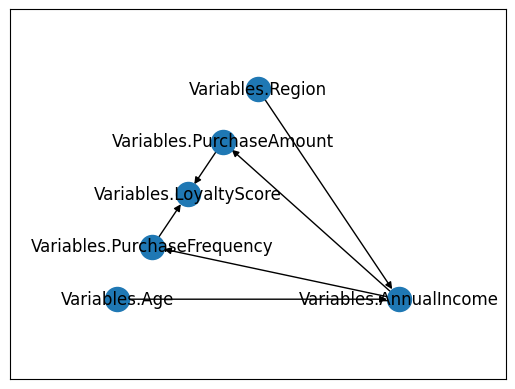

In [2]:
class Variables(str, Enum):
    Age = "age"
    Region = "region"
    AnnualIncome = "annual_income"
    PurchaseFrequency = "purchase_frequency"
    PurchaseAmount = "purchase_amount"
    LoyaltyScore = "loyalty_score"

g = nx.DiGraph([
    (Variables.Age, Variables.AnnualIncome),
    (Variables.Region, Variables.AnnualIncome),
    (Variables.AnnualIncome, Variables.PurchaseFrequency),
    (Variables.AnnualIncome, Variables.PurchaseAmount),
    (Variables.PurchaseAmount, Variables.LoyaltyScore),
    (Variables.PurchaseFrequency, Variables.LoyaltyScore),
])

nx.draw_networkx(g, pos=nx.planar_layout(g))
plt.margins(0.3)
plt.show()

purchase_model = BayesianNetwork(g)

To calculate the probabilities, we'll load the data, then try to discretize the
numeric variables to be able to compute the tabular CPD

In [3]:
df = pd.read_csv("Customer Purchasing Behaviors.csv")
df

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13
...,...,...,...,...,...,...,...
233,234,40,60000,450,7.2,West,20
234,235,38,59000,430,6.9,North,20
235,236,54,74000,630,9.4,South,27
236,237,32,52000,360,5.8,West,18


In [4]:
numeric_features = [
    Variables.Age, 
    Variables.AnnualIncome, 
    Variables.PurchaseAmount, 
    Variables.LoyaltyScore, 
    Variables.PurchaseFrequency,
]
transforms = {
    f: KBinsDiscretizer(10, encode="ordinal", strategy="uniform")
    for f in numeric_features
}

In [5]:
discrete_df = df.copy()
for f, t in transforms.items():
    discrete_df[[f]] = t.fit_transform(discrete_df[[f]].values)

Rather than computing the CPDs manually, we can pass the discrete dataset to
the fit function

In [6]:
purchase_model.fit(discrete_df)

In [7]:
purchase_model.check_model()

True

In [8]:
inference = VariableElimination(purchase_model)

We can now test the inference by using the variable elimination

In [9]:
def transform_evidence(evidence: dict[Variables, float]) -> dict[Variables, float]:
    transformed = {}
    for var, val in evidence.items():
        try:
            t = transforms[var]
            transformed[var] = t.transform([[val]])[0][0]
        except KeyError:
            transformed[var] = val
    return transformed

Which regions have loyalty score of 6?

In [10]:
evidence = transform_evidence({Variables.LoyaltyScore: 6})
result = inference.query(
    variables=[Variables.Region], 
    evidence=evidence,
)
print(result)

+-------------------------+-------------------------+
| Variables.Region        |   phi(Variables.Region) |
+=========================+=========================+
| Variables.Region(East)  |                  0.0137 |
+-------------------------+-------------------------+
| Variables.Region(North) |                  0.3709 |
+-------------------------+-------------------------+
| Variables.Region(South) |                  0.3763 |
+-------------------------+-------------------------+
| Variables.Region(West)  |                  0.2391 |
+-------------------------+-------------------------+


Double check the result of `VariableElimination` by calculating the 
probabilities manually. To do that:

* The CPDs following the path of the target variables and evidence are 
  calculated.
* The nodes not in the target variables and evidence are marginalized.
* The probability is conditioned/reduced on the evidence.


In [11]:
full_factor = factor_product(
    purchase_model.get_cpds(Variables.Region).to_factor(),
    purchase_model.get_cpds(Variables.AnnualIncome).to_factor(),
    purchase_model.get_cpds(Variables.PurchaseAmount).to_factor(),
    purchase_model.get_cpds(Variables.PurchaseFrequency).to_factor(),
    purchase_model.get_cpds(Variables.LoyaltyScore).to_factor(),
)
marginalized_factor = full_factor.marginalize(
    [
        Variables.AnnualIncome, 
        Variables.PurchaseAmount, 
        Variables.PurchaseFrequency, 
        Variables.Age,
    ], 
    inplace=False,
)
conditioned_factor = marginalized_factor.reduce(
    evidence.items(), 
    inplace=False,
)
normalized_factor = conditioned_factor.normalize(inplace=False)


In [12]:
# Too large to print. Print only if needed.
# print(full_factor)

In [13]:
print(marginalized_factor)

+-------------------------+-----------------------------+------------------------------------------------+
| Variables.Region        | Variables.LoyaltyScore      |   phi(Variables.Region,Variables.LoyaltyScore) |
+=========================+=============================+================================================+
| Variables.Region(East)  | Variables.LoyaltyScore(0.0) |                                         0.0445 |
+-------------------------+-----------------------------+------------------------------------------------+
| Variables.Region(East)  | Variables.LoyaltyScore(1.0) |                                         0.0292 |
+-------------------------+-----------------------------+------------------------------------------------+
| Variables.Region(East)  | Variables.LoyaltyScore(2.0) |                                         0.0322 |
+-------------------------+-----------------------------+------------------------------------------------+
| Variables.Region(East)  | Variables

In [14]:
print(conditioned_factor)

+-------------------------+-------------------------+
| Variables.Region        |   phi(Variables.Region) |
+=========================+=========================+
| Variables.Region(East)  |                  0.0158 |
+-------------------------+-------------------------+
| Variables.Region(North) |                  0.4056 |
+-------------------------+-------------------------+
| Variables.Region(South) |                  0.4158 |
+-------------------------+-------------------------+
| Variables.Region(West)  |                  0.2627 |
+-------------------------+-------------------------+


In [15]:
print(normalized_factor)

+-------------------------+-------------------------+
| Variables.Region        |   phi(Variables.Region) |
+=========================+=========================+
| Variables.Region(East)  |                  0.0144 |
+-------------------------+-------------------------+
| Variables.Region(North) |                  0.3688 |
+-------------------------+-------------------------+
| Variables.Region(South) |                  0.3780 |
+-------------------------+-------------------------+
| Variables.Region(West)  |                  0.2388 |
+-------------------------+-------------------------+


How much does the people with loyalty score of 9 earn?


In [16]:
result = inference.query(
    variables=[Variables.AnnualIncome], 
    evidence=transform_evidence({Variables.LoyaltyScore: 9})
)
print(result)

+-----------------------------+-------------------------------+
| Variables.AnnualIncome      |   phi(Variables.AnnualIncome) |
+=============================+===============================+
| Variables.AnnualIncome(0.0) |                        0.0000 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(2.0) |                        0.0000 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(3.0) |                        0.0066 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(4.0) |                        0.0538 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(5.0) |                        0.0124 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(6.0) |                        0.0000 |
+-----------------------------+-------------------------------+
| Variables.AnnualIncome(7.0) |         

In [17]:
transforms[Variables.AnnualIncome].bin_edges_

array([array([30000., 34500., 39000., 43500., 48000., 52500., 57000., 61500.,
              66000., 70500., 75000.])                                       ],
      dtype=object)